### 그리디 서치 디코딩
* 연속적인 모델 출력에서 이산적인 토큰을 얻는 가장 간단한 디코딩 방법은 각 타임스텝에서 확률이 가장 높은 토큰을 탐욕적으로 선택하는 것

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [5]:
model_name = 'gpt2-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--gpt2-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"]
iterations = []
n_steps = 8  # 8번의 타임스텝동안 디코딩 수행
choices_per_step = 5  # 타임스텝마다 확률이 가장 높은 토큰 5개 저장

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스 적용
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # 가장 높은 확률의 토큰을 저장
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # 예측한 다음 토큰을 입력에 추가
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (11.78%),best (6.66%),only (5.62%),first (2.91%),ultimate (2.23%)
1,Transformers are the most,popular (22.63%),successful (5.55%),famous (3.38%),powerful (3.14%),important (2.54%)
2,Transformers are the most popular,toys (8.87%),toy (7.88%),of (5.03%),Transformers (4.69%),franchise (3.88%)
3,Transformers are the most popular toys,of (31.69%),in (23.73%),ever (4.85%),", (4.50%)",for (3.58%)
4,Transformers are the most popular toys of,all (57.47%),the (21.31%),2015 (2.34%),their (1.66%),2014 (1.54%)
5,Transformers are the most popular toys of all,time (94.71%),- (1.86%),. (0.66%),", (0.56%)",times (0.52%)
6,Transformers are the most popular toys of all ...,. (34.98%),", (33.86%)",and (7.03%),! (2.16%),in (1.73%)
7,Transformers are the most popular toys of all ...,They (10.93%),\n (9.23%),The (6.63%),In (2.91%),And (2.68%)


In [8]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"]
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transformers are the most popular toys of all time. They


In [10]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"]
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, led by Dr. David R. Williams of the University of California, Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home


그리드 서치 디코딩의 주요 단점 : 반복적인 출력 시퀀스를 생성하는 경향이 있어 뉴스 기사로는 적절하지 않다.  
디코딩 측면에서 보면, 확률이 높은 단어가 확률이 낮은 단어보다 먼저 등장하기 때문에 전체적으로 확률이 높은 단어 시퀀스를 생성하지 못한다.  
이보다 더 나은 방법 : 빔 서치 디코딩

### 빔 서치 디코딩
* 각 스텝에서 확률이 가장 높은 토큰을 디코딩하는 대신, 확률이 가장 높은 상위 b개의 다음 토큰 추적 (b : 빔, 불완전 가설의 개수)
* 빔 세트는 기존 세트에서 가능한 모든 다음 토큰을 확장하고 확률이 가장 높은 b개의 확장을 선택해 구성, 이는 최대 길이나 EOS 토큰에 도달할 때까지 반복
* 확률이 가장 높은 시퀀스는 **로그 확률**에 따라 b개 빔의 순위를 매겨 선택됨
    * 로그 확률 사용하는 이유 : 시퀀스의 전체 확률을 계산하려면 조건부 확률의 곱을 계산해야 하기 때문 (조건부 확률이 0-1 범위 안에 속한 작은 값이므로 언더플로 발생)

In [11]:
# 트랜스포머 모델은 입력 토큰이 주어지면 다음 토큰에 대한 정규화되지 않은 로짓 반환
# 따라서 먼저 로짓을 정규화해서 시퀀스의 각 토큰을 위해 전체 어휘사전에 대한 확률분포 만든 후, 시퀀스에 있는 토큰 확률만 선택
import torch.nn.functional as F

# 하나의 토큰에 대한 로그 확률 제공
def log_probs_from_logits(logits, labels) :
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [12]:
# 시퀀스의 전체 로그 확률을 얻으려면 각 토큰의 로그 확률 더함
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        # 로짓과 레이블 정렬이 중요
        # 모델은 다음 토큰을 예측하기에 첫 번째 레이블에 대한 로짓 얻지 못함
        # 마지막 로짓에 대한 정답 없기에 마지막 로짓 필요하지 않음
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [13]:
# 그리디 서치
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, led by Dr. David R. Williams of the University of California, Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home

로그 확률: -86.50


In [14]:
# 빔서치로 생성한 시퀀스와 비교
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, # 빔 크기 클수록 더 좋을 가능성 높지만 느림
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of researchers from the University of California, Santa Cruz, and the University of California, Santa Cruz, and published in the Journal of Mammalogy.


The team, led by Dr. David Hone of the University of California, Santa Cruz, discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains.




로그 확률: -65.20


단순히 그리디 서치보다 빔 서치에서 더 높은 로그 확률 얻음  
하지만, 빔 서치도 텍스트가 반복되는 문제 있음   
=> no_repeat_ngram_size로 n-그램 페널티 부과 방법 : n-그램을 추적해 다음 토큰 확률이 0이 됨

In [15]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of researchers from the University of California, Santa Cruz, and the National Geographic Society. The team was led by Dr. Richard Wrangham, a professor of ecology and evolutionary biology at UCSC.

"We've known for a long time that there are animals that live in remote areas of the world, but this is the first time we've been able

로그 확률: -79.02


반복적인 텍스트 생성을 막고 점수는 더 낮아졌지만, 텍스트 일관성 유지  
n-그램 페널티를 사용한 빔 서치는 확률이 높은 토큰에 초점을 맞추는 빔서치와 반복을 줄이는 n-그램 페널티의 균형을 잡는 좋은 방법

### 샘플링 방법
* 온도가 생성되는 텍스트에 어떤 영향을 미치는지

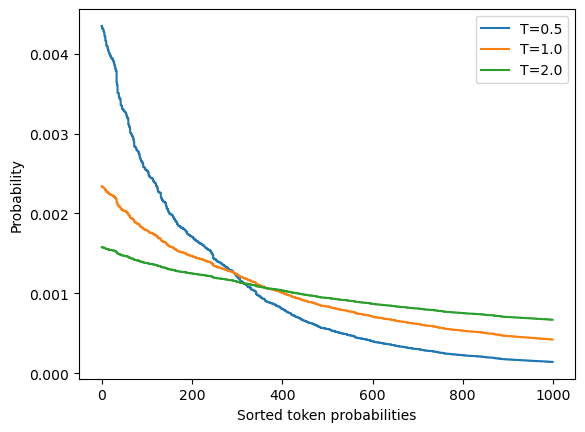

In [17]:
#세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

T << 1 일 때, 원점 근처에서 정점에 도달하고 드문 토큰 억제  
T >> 1 일 때, 분포가 평평해지고 각 토큰의 확률이 동일해짐

In [18]:
# T = 2 : 온도가 높으면 횡설수설에 가까운 텍스트 : 드문 토큰이 강조되어 모델이 이상한 문법 만들고 다양한 가짜 단어 생성
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Located Alienrous south officials organ overboard RX Cloud ballet at Sonny Pioneer Pictures studio punishing Take ge rejecting Preston Sprree Von midSteve decisive developmentTrekk F govern Gentana reporting repression spectacular SplashPhase Zealandographed likened Applpects Coke665 Honestly mat calmedovich organisms SQU Forbes coordinate A bombique poverty legacy pool superior transaction flusheconomic acknowledges Cultihuenger suckercard CrashCourse 2022 Chocolate kernels latest Taxi dude prevalenceHungfinPoly


In [19]:
# T = 0.5 : 온도가 낮으면 텍스트 일관성, 발견에 기여한 다른 대학도 언급
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists were surprised to find the unicorns living in a remote valley in the Andes Mountains, in Chile, and that the animals were able to communicate with each other in English.

"The unicorns were able to communicate in English, and we were able to understand them very well," said Dr. Stephen G. Martin, an associate professor of biology at the University of Colorado. "We


온도(T) 매개변수는 샘플의 품질을 제어하지만, 항상 일관성(낮은 온도)과 다양성(높은 온도)의 균형점이 있기에 조정해야 한다.
* 어휘사전의 분포를 잘라내는 방법
    * 온도와 함께 다양성을 자유롭게 조정하지만, 
    더 제한된 범위에서 문맥상 매우 이상한 단어(확률이 낮은)를 제외한다.
    * Top-K Sampling
    * nucleus sampling(Top-P Sampling)
    
### 탑-k 및 뉴클리어스 샘플링
두 샘플링 모두 각 타임스텝에서 샘플링에 사용할 토큰의 개수를 줄인다.
* 탑-k 샘플링
    * 확률이 가장 높은 k개 토큰에서만 샘플링해 확률이 낮은 토큰 피함
    * 확률분포의 롱테일은 잘라내고 확률이 가장 높은 토큰에서만 샘플링하는 것이 가능
    * 누적확률 그래프에서 수직선을 정의하고 왼쪽에 있는 토큰에서만 샘플링
        * 누적확률 그래프 : 내림차순으로 정렬된 토큰 확률의 누적 분포

In [20]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"]

In [21]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

In [22]:
# top-k
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Dr. Gert Rydstrup of the University of Bergen said: "Our understanding of the genetic relationship between unicorns and humans is still a bit of a mystery. "One of the key points that's being looked at in our research is whether they have close genetic ties, which would in turn make a strong case that they are a hybrid species. Our view based on genetic studies is that


k값 ?  
k값은 수동으로 선택해야 하고, 실제 출력 분포에 상관없이 시퀀스의 각 선택에 동일하게 적용  
고정된 컷오프는 만족스럽지 않은 경우 있다.  
=> 동적인 컷오프 적용 : **top-p**  
* 어디서 컷오프를 할 지 조건을 지정한다. (조건은 선택한 특정확률질량에 도달할 때)  
* 그다음 확률에 따라 내림차순으로 모든 토큰을 정렬하고 선택한 토큰의 확률 값이 p에 도달할 때까지 이 리스트의 맨 위부터 토큰 하나씩 추가
    * p : 누적확률 그래프의 수평선
    * 이 수평선 아래에 있는 토큰에서만 샘플링

In [23]:
# top-p
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The unicorns have not yet been named, but the scientists speculate that they might be related to the North American species, Eucalyptus sylvestris. This one, the researchers believe, was probably brought to South America by humans.


They are the first species of unicorn discovered on Earth. "These are big and magnificent animals, with a large horn and an antler, but


두 샘플링 방법을 연결하면 (topk = 50, topp = 0.9) 확률이 가장 높은 50개 토큰에서 확률 질량이 90%인 토큰 선택